In [231]:
import iris
import iris.coord_categorisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import warnings

warnings.filterwarnings('ignore')
#%matplotlib tk

In [232]:
def region(coords):
    if len(coords) == 4:
        loni, lati, lonf, latf = coords
        region_subset = iris.Constraint(longitude=lambda cell: loni <= cell <= lonf,
                                        latitude=lambda cell: lati <= cell <= latf)
    else:
        print('Wrong number of elements in the coordinate array.')
    return region_subset
    
def low_pass_weights(window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = np.arange(1., n)
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n - 1:0:-1] = firstfactor * sigma
    w[n + 1:-1] = firstfactor * sigma
    return w[1:-1]


def lanczos_filter(cube, window=101, low=1. / 100., high=1. / 20.):
    wgts_high = low_pass_weights(window, high)
    wgts_low = low_pass_weights(window, low)

    cube = cube - cube.collapsed('time', iris.analysis.MEAN)
    cube_filt = cube.copy()

    cube_filt.data = np.apply_along_axis(lambda m: (np.convolve(m, wgts_high, mode='same') -
                                                    np.convolve(m, wgts_low, mode='same')), axis=0, arr=cube.data)
    return cube_filt


In [233]:
def compute_ceofs_2d(olr_filt, u850_filt, u200_filt):
    # Assuming 'olr_filt', 'u850_filt', and 'u200_filt' are your Iris cubes (time, lat, lon)
    # Reshape data (time, lat*lon) for each variable
    olr_2d = olr_filt.data.reshape(olr_filt.shape[0], -1)
    u850_2d = u850_filt.data.reshape(u850_filt.shape[0], -1)
    u200_2d = u200_filt.data.reshape(u200_filt.shape[0], -1)
    
    # Step 1: Normalize each variable by its standard deviation across time
    olr_norm = olr_2d / np.std(olr_2d, axis=0)
    u850_norm = u850_2d / np.std(u850_2d, axis=0)
    u200_norm = u200_2d / np.std(u200_2d, axis=0)
    
    # Step 2: Combine the normalized data along the spatial dimension (concatenating columns)
    combined_data = np.hstack([olr_norm, u850_norm, u200_norm])
    
    # Step 3: Remove the mean over time (anomalies)
    combined_anomalies = combined_data - np.mean(combined_data, axis=0)
    
    # Step 4: Perform Singular Value Decomposition (SVD)
    U, s, Vt = np.linalg.svd(combined_anomalies, full_matrices=False)
    
    # Step 5: Extract the first two EOFs
    # Vt contains the spatial patterns (EOFs) in flattened form; we need to reshape them back
    
    # EOF 1
    eof1_olr = Vt[0, :olr_2d.shape[1]].reshape(olr_filt.shape[1], olr_filt.shape[2])  # Reshape to (lat, lon)
    eof1_u850 = Vt[0, olr_2d.shape[1]:olr_2d.shape[1]+u850_2d.shape[1]].reshape(u850_filt.shape[1], u850_filt.shape[2])
    eof1_u200 = Vt[0, olr_2d.shape[1]+u850_2d.shape[1]:].reshape(u200_filt.shape[1], u200_filt.shape[2])
    
    # EOF 2
    eof2_olr = Vt[1, :olr_2d.shape[1]].reshape(olr_filt.shape[1], olr_filt.shape[2])  # Reshape to (lat, lon)
    eof2_u850 = Vt[1, olr_2d.shape[1]:olr_2d.shape[1]+u850_2d.shape[1]].reshape(u850_filt.shape[1], u850_filt.shape[2])
    eof2_u200 = Vt[1, olr_2d.shape[1]+u850_2d.shape[1]:].reshape(u200_filt.shape[1], u200_filt.shape[2])
    
    # Step 6: Extract the first two principal components (time series)
    pc1 = U[:, 0] * s[0]
    pc2 = U[:, 1] * s[1]

    return [eof1_olr, eof2_olr], [eof1_u850, eof2_u850], [eof1_u200, eof2_u200], [pc1, pc2]

In [247]:
mem_labels = [f'{fc:03}' for fc in range(0, 17)]
date_label = '20250521'

outfile_dir = '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/'
files = [os.path.join(outfile_dir, f'olr_120dm_40sn_nrt_{date_label}_{mem}.nc') for mem in
                        mem_labels]
files = [file for file in files if os.path.exists(file)]
files

['/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_000.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_001.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_002.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_003.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_004.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_005.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_006.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_007.nc',
 '/data/scratch/prince.xavier/SALMON/processed_SEA_data/mogreps/mjo/olr/olr_120dm_40sn_nrt_20250521_008.nc',
 '/data/scratch/pri

In [248]:
cube_dummy = iris.load_cube(files[0])#.extract(region([0, -15, 357.5, 15]))
cube_dummy.shape

(47, 33, 145)

In [249]:
# Create array of shape (nmembers, 33, 145)
ens_data = np.empty((len(mem_labels), *cube_dummy.shape))  # or np.zeros / np.full
ens_data.shape

(17, 47, 33, 145)

In [250]:
for i, file in enumerate(files):
    #print(i)
    ens_data[i] = iris.load_cube(file).data#.extract(region([0, -15, 357.5, 15])).data

In [251]:
ens_data.shape

(17, 47, 33, 145)

(30.0, 47.0)

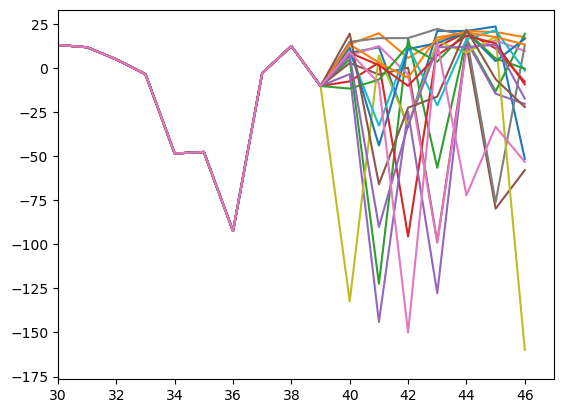

In [252]:
for i in range(17):
    plt.plot(ens_data[i,:, 15, 70])
plt.xlim([30, 47])

In [253]:
#data = olr_cube.data
fft_data = np.fft.fft(ens_data)

# FFT along longitude (axis=-1)
fft_data = np.fft.fft(ens_data, axis=-1)

# Zero out all wavenumbers except 1 to 5 and -1 to -5
kmin, kmax = 1, 5
n_lon = data.shape[-1]

filtered_fft = np.zeros_like(fft_data, dtype=complex)

# Keep wavenumbers +1 to +5
#filtered_fft[..., kmin:kmax + 1] = fft_data[..., kmin:kmax + 1]
# Keep symmetric negative wavenumbers (for real-valued result)
#filtered_fft[..., -kmax-1:-kmin] = fft_data[..., -kmax-1:-kmin]
#print(kmin, kmax+1, -kmax, -kmin)

# Filter: keep only eastward wavenumbers (positive 1–5), optionally include wavenumber 0
#filtered_fft[..., 0] = fft_data[..., 0]  # Optional: keep mean
filtered_fft[..., kmin:kmax + 1] = fft_data[..., kmin:kmax + 1]

# Inverse FFT to get filtered data back in physical space
filtered_data = np.fft.ifft(filtered_fft, axis=-1).real  # take real part

In [254]:
filtered_data.shape
# Boolean mask where condition is met
exceeds = filtered_data < -10

# Compute the probability (fraction of members > 10)
probability = np.sum(exceeds, axis=0) / filtered_data.shape[0]

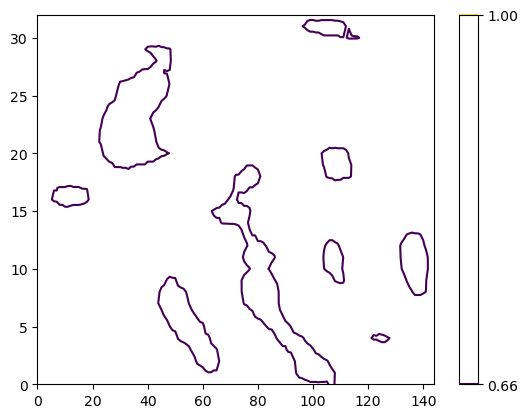

In [259]:
plt.contour(probability[-4], levels=[0.66, 1])
plt.colorbar()

In [244]:
filtered_data.shape

(17, 208, 73, 145)

(39.0, 47.0)

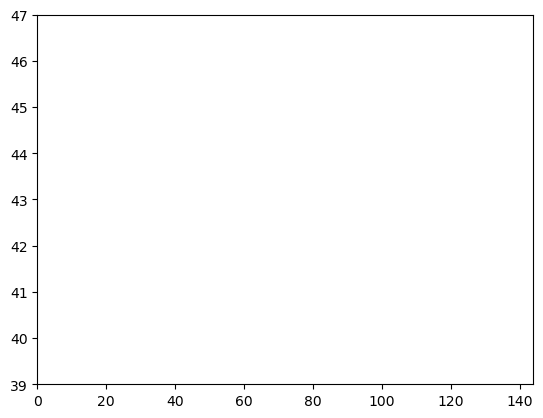

In [245]:
for i in range(17):
    #plt.contour(filtered_data[i, 46], levels=[-20], alpha=0.3)
    plt.contour(filtered_data[i,:, 15], levels=[-20],alpha=0.3)#, levels=np.linspace(-120, 120, 11), colors='black')
plt.ylim([39, 47])
#fft_data[0, 15].shape

TypeError: Input z must be 2D, not 3D

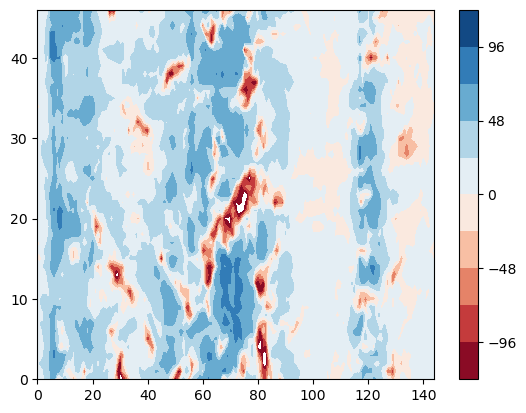

In [210]:
plt.contourf(data[:,10], levels=np.linspace(-120, 120, 11), cmap='RdBu')
plt.colorbar()
plt.contour(filtered_data[:,10], levels=np.linspace(-120, 120, 11), colors='black')

In [20]:
olr_filt = lanczos_filter(olr_cube)
u850_filt = lanczos_filter(u850_cube)
u200_filt = lanczos_filter(u200_cube)

In [21]:
olr_filt.shape, u850_filt.shape, u200_filt.shape

((7305, 13, 144), (7305, 13, 144), (7305, 13, 144))

In [22]:
olr_eofs, u850_eofs, u200_eofs, pcs = compute_ceofs_2d(olr_filt, u850_filt, u200_filt)

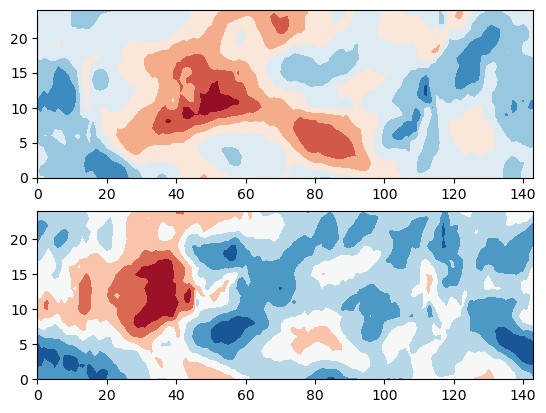

In [18]:
plt.subplot(211)
plt.contourf(olr_eofs[0], cmap='RdBu')
plt.subplot(212)
plt.contourf(olr_eofs[1], cmap='RdBu')
#plt.colorbar()
#qplt.plot(olr_filt[:, 10, 70] + olr_cube[:, 10, 70].collapsed('time', iris.analysis.MEAN))

In [12]:
anom_120_filenames = {'olr': '/scratch/hadpx/SEA_monitoring/processed_SEA_data/mogreps/MJO/olr/olr_120dm_40sn_nrt_20241016_005.nc',
                      'u850':'/scratch/hadpx/SEA_monitoring/processed_SEA_data/mogreps/MJO/u850/u850_120dm_40sn_nrt_20241016_005.nc',
                      'u200':'/scratch/hadpx/SEA_monitoring/processed_SEA_data/mogreps/MJO/u200/u200_120dm_40sn_nrt_20241016_005.nc'}

In [15]:
# Check all 3 files exist
all_files_exist = all(os.path.exists(file_path) for file_path in anom_120_filenames.values())
assert all_files_exist, 'Some files do not exist.'
all_files_exist

True

In [19]:
# Reading a sample data to create the array
cube = iris.load_cube(anom_120_filenames['olr'])

# 15S-15N lat average
# here we only need 144 lon values
cube = cube.extract(region([0, -15, 357.5, 15]))
cube = cube.collapsed(['latitude'], iris.analysis.MEAN)
ntime, mlon = cube.shape
ntime, mlon

/opt/scitools/conda/deployments/default-2024_05_28/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


(47, 144)

In [20]:
# Large array to hold all the variables
cdata = np.zeros((ntime, 3 * mlon))
for n, varname in enumerate(['olr', 'u850', 'u200']):  # 0:2 are OLR, u850, u200
    cube = iris.load_cube(anom_120_filenames[varname])

    # lat average
    # here we only need 144 lon values
    cube = cube.extract(region([0, -15, 357.5, 15]))
    cube = cube.collapsed(['latitude'], iris.analysis.MEAN)

    # Combine the data into one variable
    cdata[:, n * mlon: (n + 1) * mlon] = cube.data

/opt/scitools/conda/deployments/default-2024_05_28/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/opt/scitools/conda/deployments/default-2024_05_28/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/opt/scitools/conda/deployments/default-2024_05_28/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


In [21]:
cdata.shape

(47, 432)

In [57]:
pc_olr = []
pc_u850 = []
pc_u200 = []
# Now work on one time at a time as in the createRMM1RMM2.f
for t in range(ntime):
    # normalise datmat for each time
    datmat = (cdata[t, :] - databar) / norm

    #  Compute RMM1 and RMM2  (the first two normalized PCs)
    # Do the computation in 3 parts, one for each variable, so
    # that we can compute the contribution from each variable

    pcolr = np.dot(np.transpose(eigvec[0:nsp1, 0:2]), datmat[0:nsp1])
    pcu850 = np.dot(np.transpose(eigvec[nsp1:nsp2, 0:2]), datmat[nsp1:nsp2])
    pcu200 = np.dot(np.transpose(eigvec[nsp2:nsp3, 0:2]), datmat[nsp2:nsp3])
    
    pcolr = pcolr / np.sqrt(eigval[0:2])
    pcu850 = pcu850 / np.sqrt(eigval[0:2])
    pcu200 = pcu200 / np.sqrt(eigval[0:2])
    
    pc_olr.append(pcolr)
    pc_u850.append(pcu850)
    pc_u200.append(pcu200)
    #pc = pcolr + pcu850 + pcu200

    #rmm1s.append(pc[0])
    #rmm2s.append(pc[1])

47

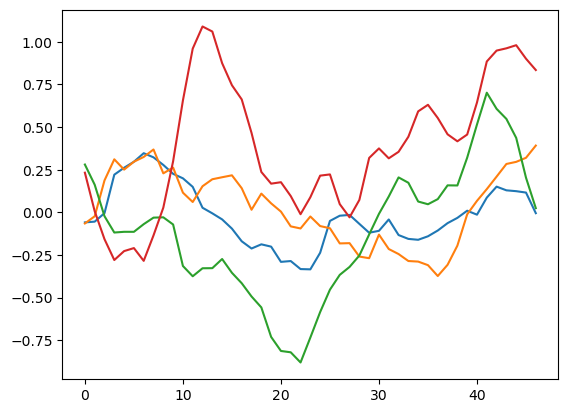

In [58]:
#plt.plot(eigvec[0:nsp1, 0:2])
plt.plot(pc_olr)
#plt.plot(pc_u850)
plt.plot(pc_u200)
#plt.plot(norm)
len(pc_olr)

In [71]:
filenames = [f'/scratch/hadpx/SEA_monitoring/processed_SEA_data/mogreps/MJO/olr/olr_120dm_40sn_nrt_20241016_{mem:03}.nc' 
             for mem in range(36) if os.path.exists(f'/scratch/hadpx/SEA_monitoring/processed_SEA_data/mogreps/MJO/olr/olr_120dm_40sn_nrt_20241016_{mem:03}.nc')]

data_list = []
for filename in filenames:
    cube = iris.load_cube(filename)
    data_list.append(cube.data)

In [85]:
data_array = np.array(data_list)
# Step 2: Sum the True values (which are 1s) along the 0th dimension
counts = np.sum(data_array<=-10, axis=0) / data_array.shape[0]

counts.shape

counts_cube = cube.copy()
counts_cube.data = counts
# Step 3: Calculate the fraction by dividing by the number of elements along the 0th dimension (36 in this case)
#fraction_exceeding_10 = count_exceeding_10 / arr.shape[0]

In [91]:
#np.dot(np.transpose(eigvec[0:nsp1, 0:2]), datmat[0:nsp1])
#olr_hov = np.dot(np.array(pc_olr), np.transpose(eigvec[0:nsp1, 0:2]))
tcube = counts_cube.extract(region([0, -15, 357.5, 15]))
olr_hov = tcube.collapsed('latitude', iris.analysis.MEAN)

/opt/scitools/conda/deployments/default-2024_05_28/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(


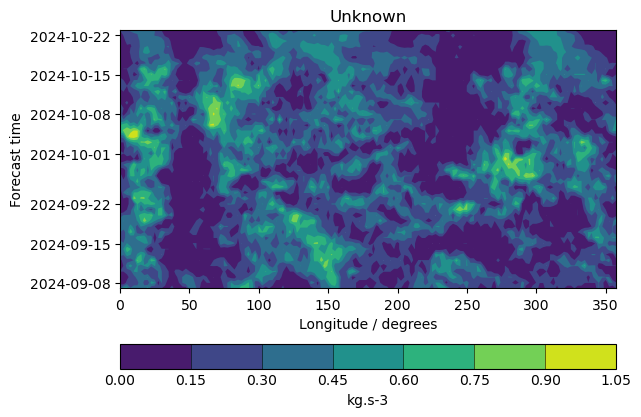

In [93]:
qplt.contourf(olr_hov)
#plt.gca().coastlines()
#plt.colorbar()